In [1]:
import pandas as pd
import numpy as np
import scanpy
import phate
import scprep
import matplotlib.pyplot as plt
import magic
import leidenalg
import seaborn as sns
from sklearn.preprocessing import scale
import pandas as pd

In [2]:
acute = scanpy.read_h5ad('data/acute_tcells.h5ad')
chronic = scanpy.read_h5ad('data/chronic_tcells.h5ad')

In [3]:
adata = scanpy.concat((acute,chronic))
adata.obs['batch'] = adata.obs['batch'].astype('category')

In [4]:
phate_op = phate.PHATE(random_state=42, n_jobs=-1, knn=30)
adata.obsm['X_phate'] = phate_op.fit_transform(adata.to_df())

Calculating PHATE...
  Running PHATE on 39704 observations and 14152 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 12.75 seconds.
    Calculating KNN search...
    Calculated KNN search in 95.01 seconds.
    Calculating affinities...
    Calculated affinities in 10.21 seconds.
  Calculated graph and diffusion operator in 119.13 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 14.37 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.59 seconds.
  Calculated landmark operator in 18.87 seconds.
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 1.40 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.19 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.70 seconds.
Calculated PHATE in 144.30 seconds.


In [5]:
gene_embedding_results = np.load('results/GSPA_QR_without_regression.npz', allow_pickle=True)

In [6]:
data_ae = gene_embedding_results['signal_embedding']
localization = gene_embedding_results['localization_score']
hvgs = gene_embedding_results['genes']

In [7]:
gene_phate_op = phate.PHATE(random_state=42)
data_phate = gene_phate_op.fit_transform(data_ae)

Calculating PHATE...
  Running PHATE on 1416 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.47 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.78 seconds.
  Calculating optimal t...
    Automatically selected t = 24
  Calculated optimal t in 0.58 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.12 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.62 seconds.
Calculated PHATE in 3.11 seconds.


In [8]:
magic_op = magic.MAGIC()
data_magic = magic_op.fit_transform(adata.to_df(), genes=hvgs, graph=phate_op.graph)

Calculating MAGIC...
  Running MAGIC on 39704 cells and 14152 genes.
  Using precomputed graph and diffusion operator...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


  Calculating imputation...
  Calculated imputation in 31.74 seconds.
Calculated MAGIC in 34.32 seconds.


## Get cell clusters

In [9]:
localization = pd.Series(localization, index=hvgs)

In [10]:
cell_clusters = np.array(leidenalg.find_partition(phate_op.graph.to_igraph(), 
                                                  leidenalg.ModularityVertexPartition,
                                                  seed=0).membership)

In [11]:
adata.obs['clusters'] = cell_clusters.astype(str)

In [12]:
scanpy.tl.rank_genes_groups(adata, groupby='clusters', method='wilcoxon', )

<Axes: >

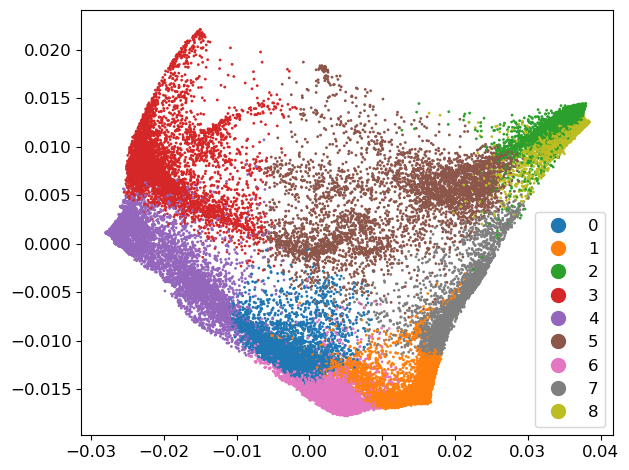

In [21]:
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['clusters'])

In [24]:
pd.DataFrame(adata.uns['rank_genes_groups']['names'])

,0,1,2,3,4,5,6,7,8
0,S100a4,Ccl5,Rps24,Ptma,Hmgb2,Ifi27l2a,Ccl5,Il7r,Rps29
1,S100a6,Jund,Rps9,Pclaf,Stmn1,Rpl32,Gzma,Rps21,Rps28
2,S100a11,Ahnak,Rps20,Hmgb2,Rbm3,Rps20,Klrg1,Rps27,Rpl35a
3,Lgals3,Klf2,Rpl19,Ran,H2afz,Rpl10a,Rap1b,Junb,Rps24
4,Pglyrp1,Junb,Fau,Ppia,Hmgn2,Tmsb10,Cx3cr1,Rps29,Rps27
...,...,...,...,...,...,...,...,...,...
14147,Rps28,Rpl10a,Nkg7,H2-K1,Rpl19,Itga4,Rps26,Cfl1,AW112010
14148,Rpl41,Rps2,S100a6,Hcst,Rpl36,Klf2,Ly6e,Tmsb4x,Lgals1
14149,Rps20,Ly6e,Actb,Fau,Fau,Lgals3,Rps2,Pfn1,Ccl5
14150,Rpl35a,Rpsa,Ccl5,Rps27,Rpl37a,Emp3,Ptma,Gzmb,Nkg7


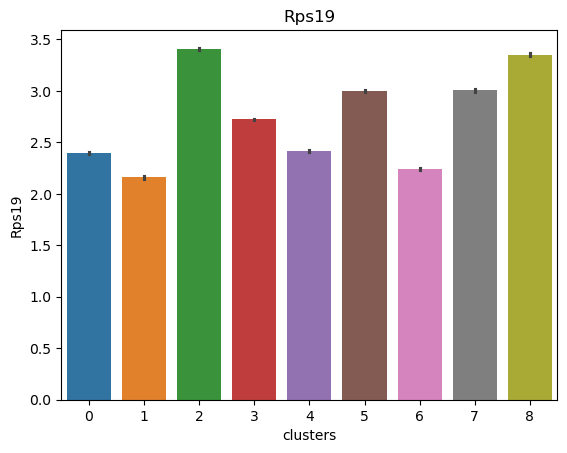

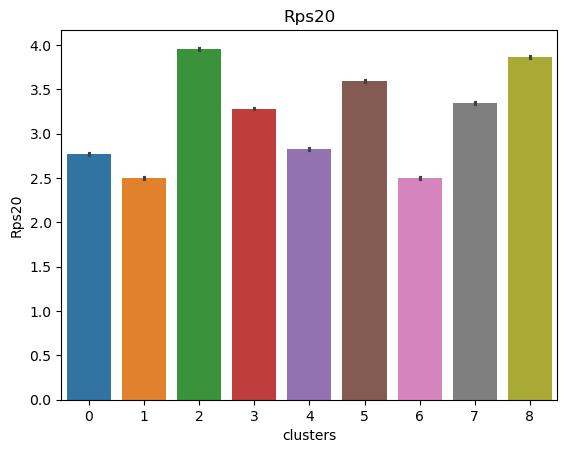

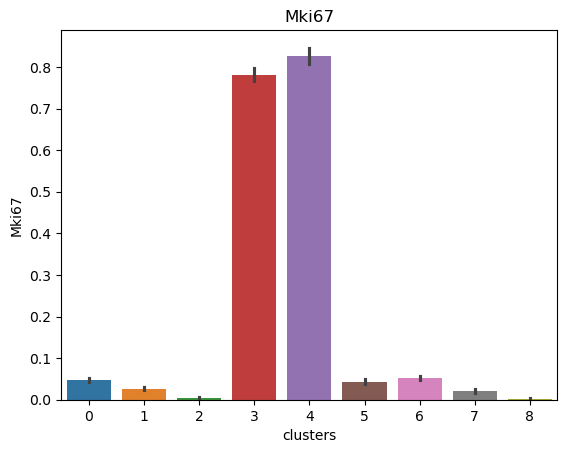

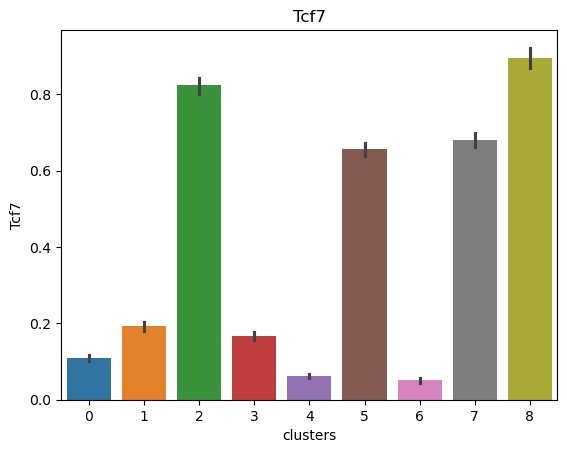

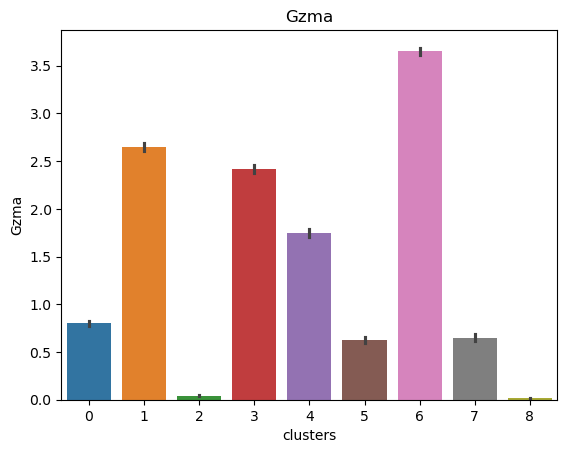

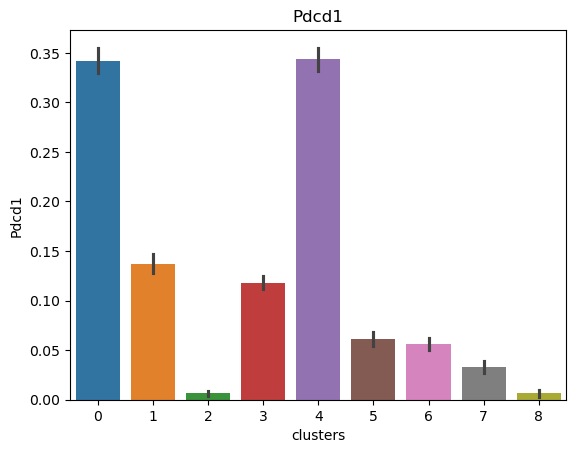

<Figure size 640x480 with 0 Axes>

In [29]:
for gene in ['Rps19', 'Rps20', 'Mki67', 'Tcf7', 'Gzma', 'Pdcd1']:
    sns.barplot(x=adata.obs['clusters'], y=adata.to_df()[gene], hue=adata.obs['clusters'])
    plt.title(gene); plt.show(); plt.clf()

## Compute cell clustering rank

In [13]:
genes_max_score_clustering = []
for gene in hvgs:
    max_score = -1
    for cluster in [str(x) for x in range(cell_clusters.max() + 1)]:
        score = dict(zip(adata.uns['rank_genes_groups']['names'][cluster], 
                         adata.uns['rank_genes_groups']['scores'][cluster]))[gene]
        if score > max_score:
            max_score = score
    genes_max_score_clustering.append(max_score)

## comparison with localization

In [14]:
gene_summary = pd.read_csv('results/gene_summary.csv', index_col=0)
gene_summary['clustering_rank'] = genes_max_score_clustering
gene_summary.to_csv('results/gene_summary.csv')

In [20]:
gene_summary[gene_summary.columns[1:]].corr(method='spearman')

,localization_score,clustering_rank
localization_score,1.000000,0.326755
clustering_rank,0.326755,1.000000


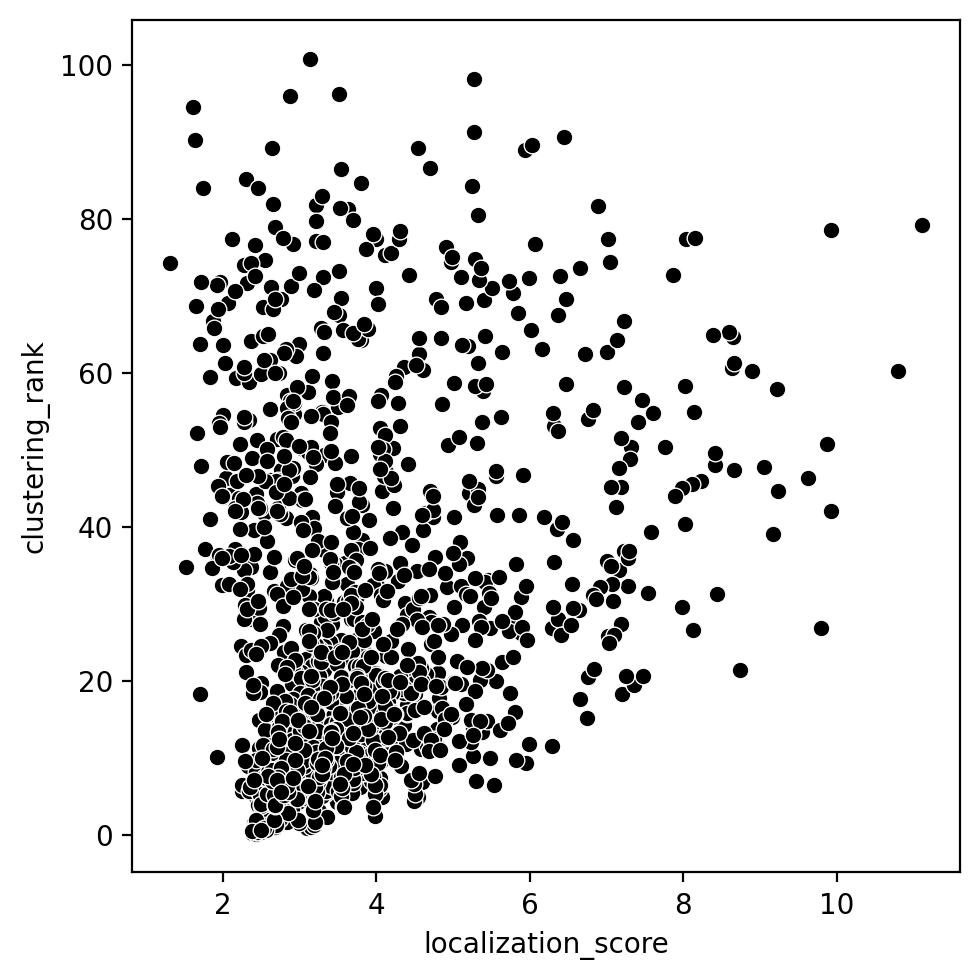

In [16]:
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
sns.scatterplot(x=gene_summary['localization_score'], y=gene_summary['clustering_rank'], ax=ax, color='black')
plt.tight_layout()
fig.savefig('figures/localization_vs_clustering.png', dpi=200)

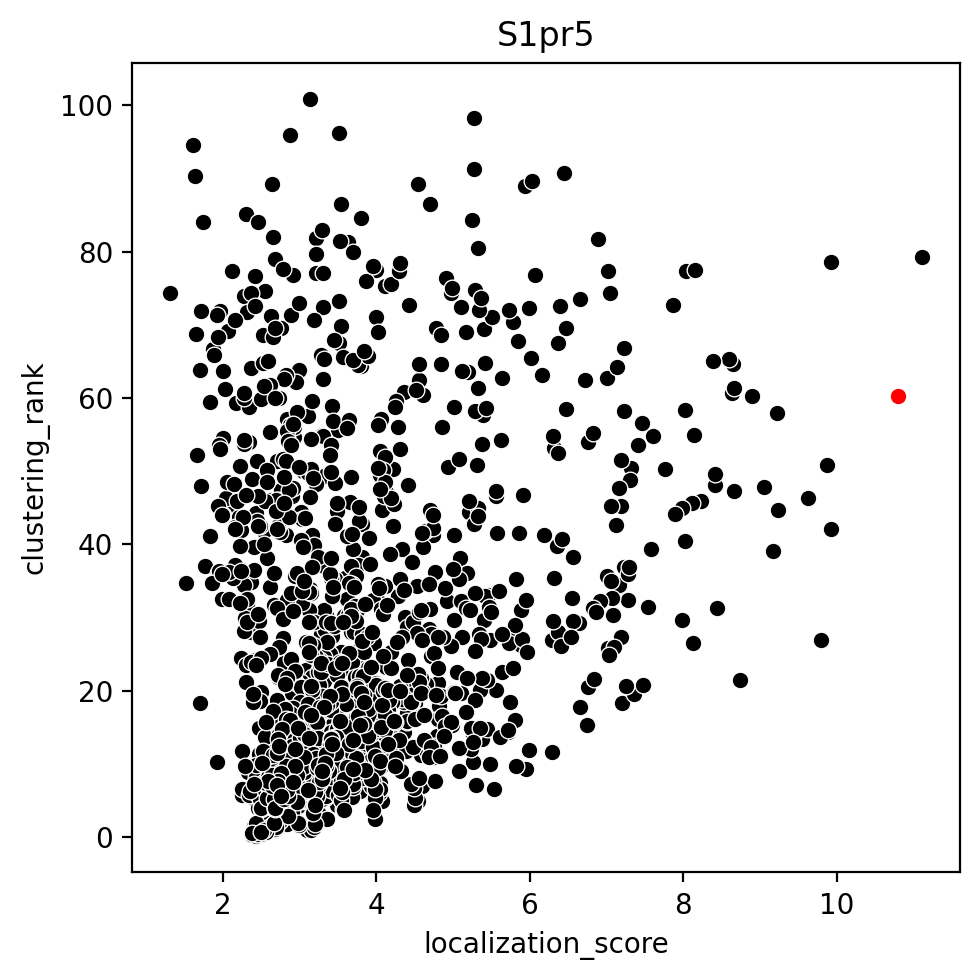

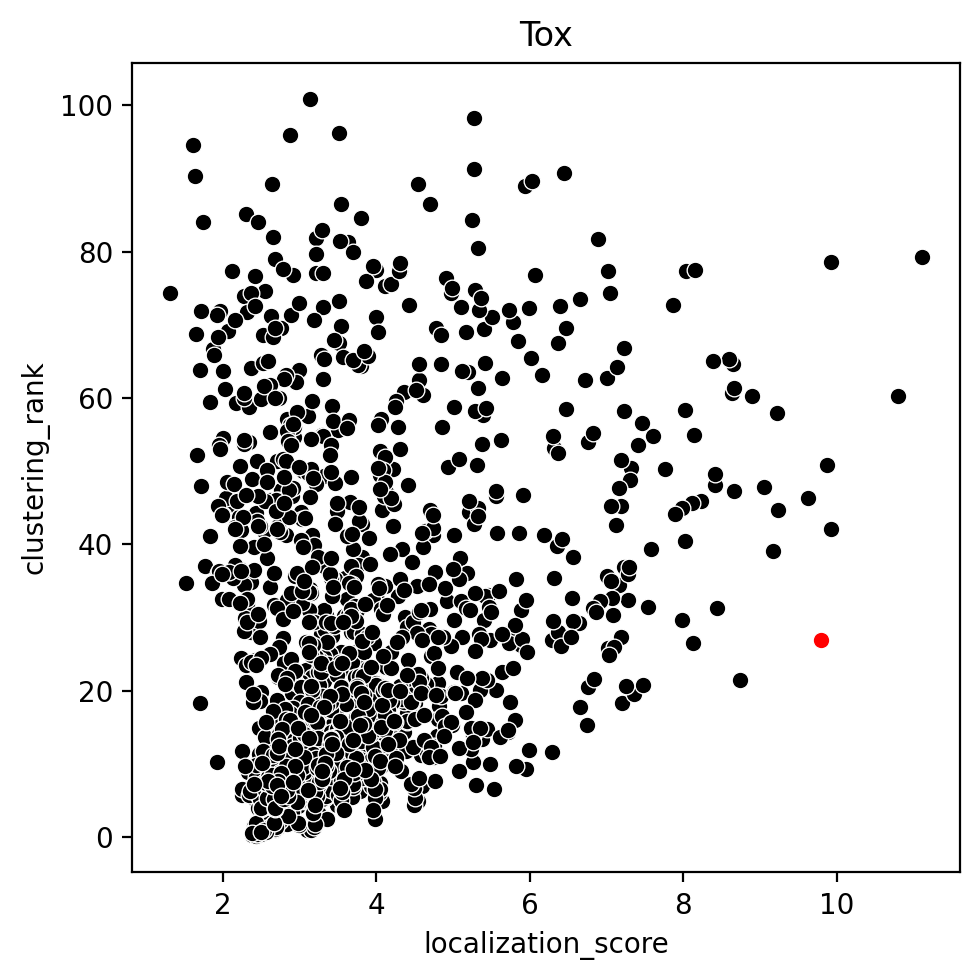

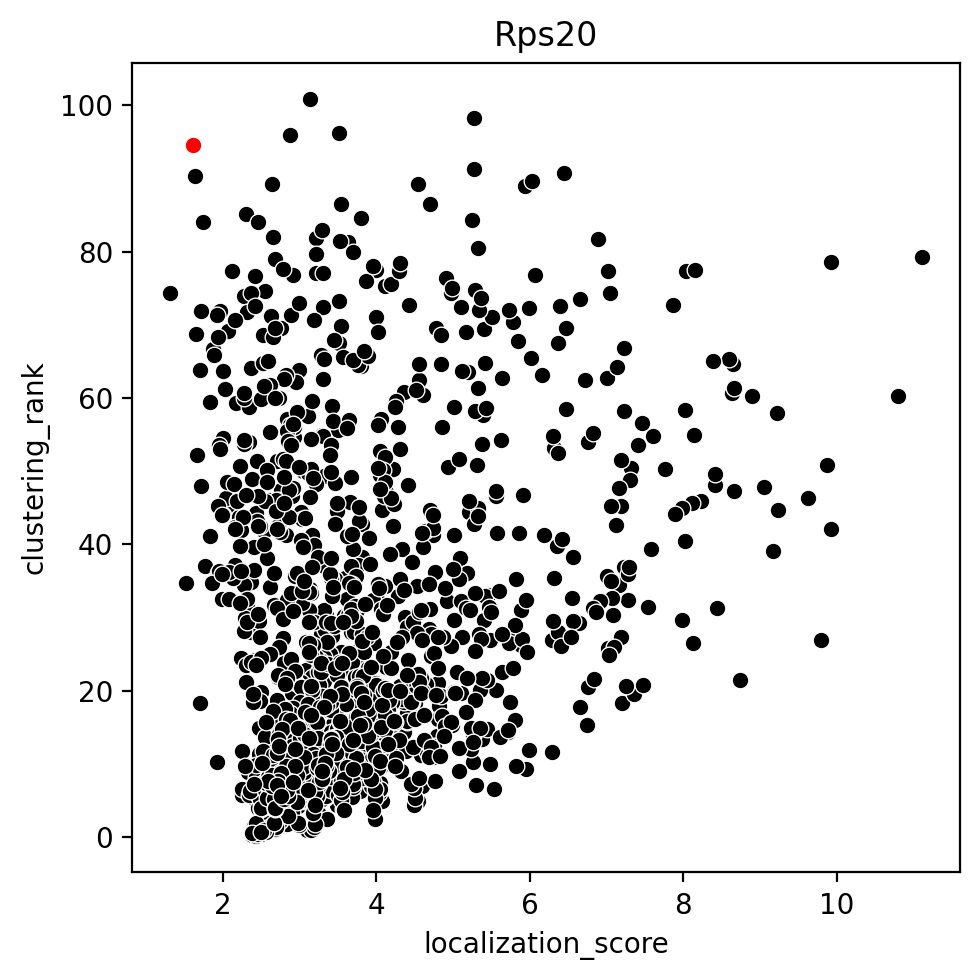

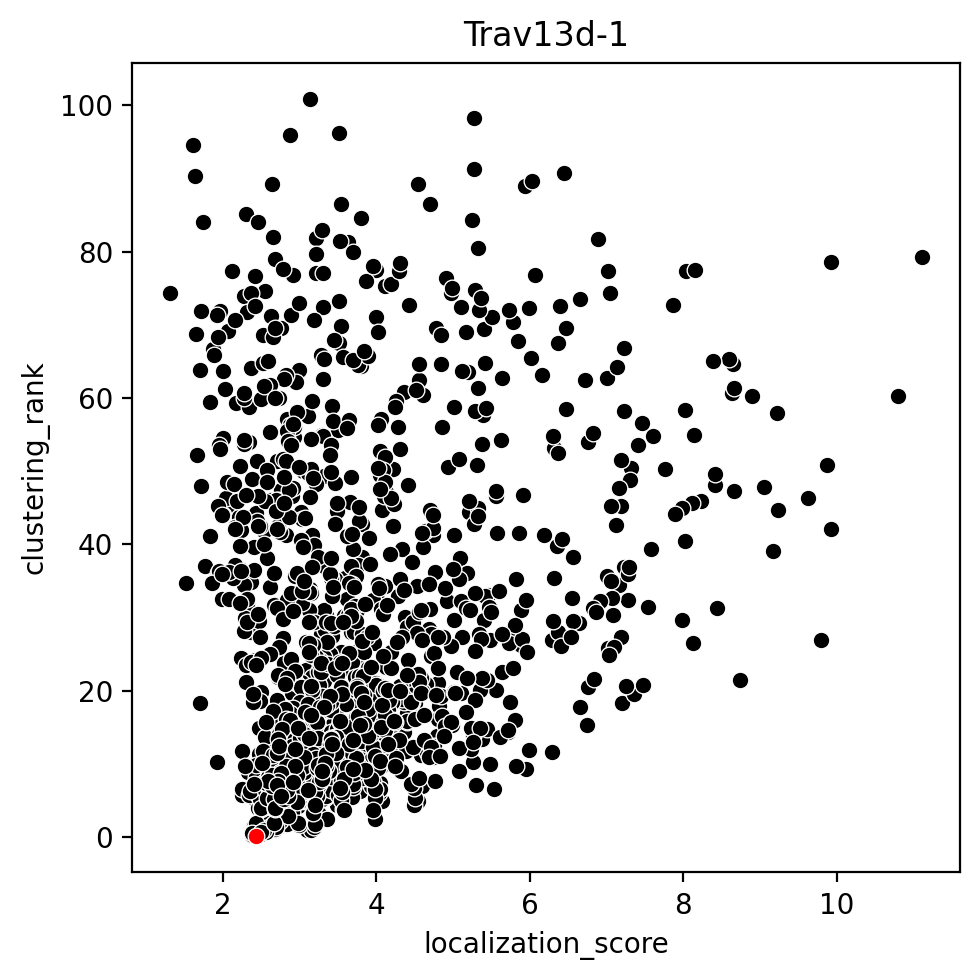

In [17]:
for gene in ['S1pr5', 'Tox', 'Rps20', 'Trav13d-1']:
    fig, ax = plt.subplots(figsize=(5,5), dpi=200)
    sns.scatterplot(x=gene_summary['localization_score'], y=gene_summary['clustering_rank'], ax=ax, 
                    color='black')
    sns.scatterplot(x=gene_summary['localization_score'].loc[[gene]], y=gene_summary['clustering_rank'].loc[[gene]], ax=ax, 
                    color='red')
    plt.title(gene)
    plt.tight_layout()

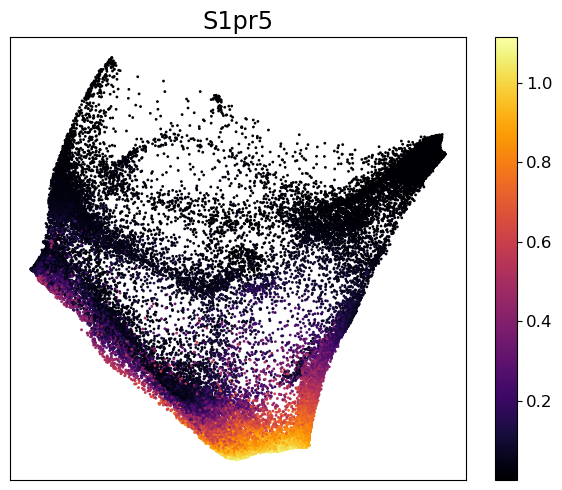

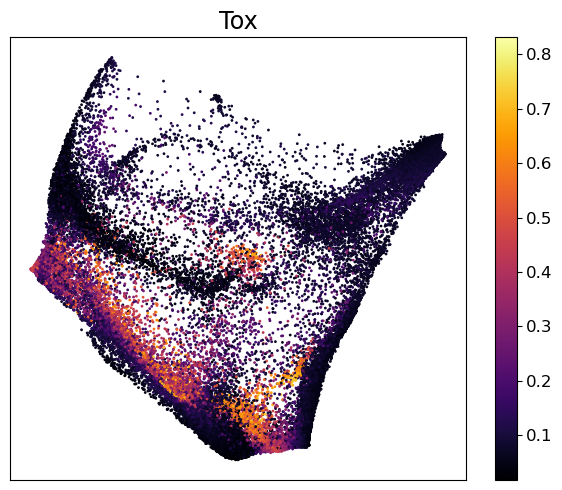

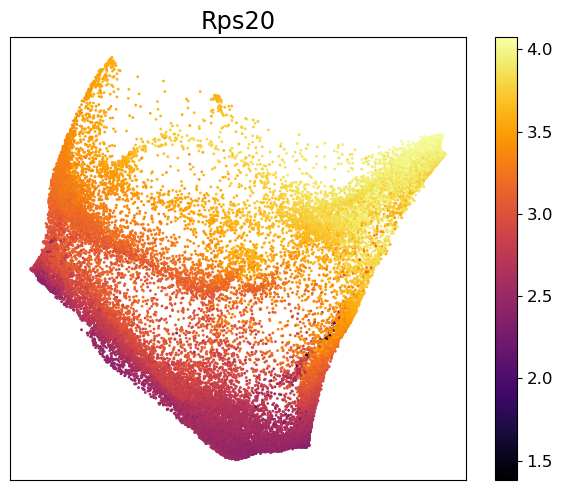

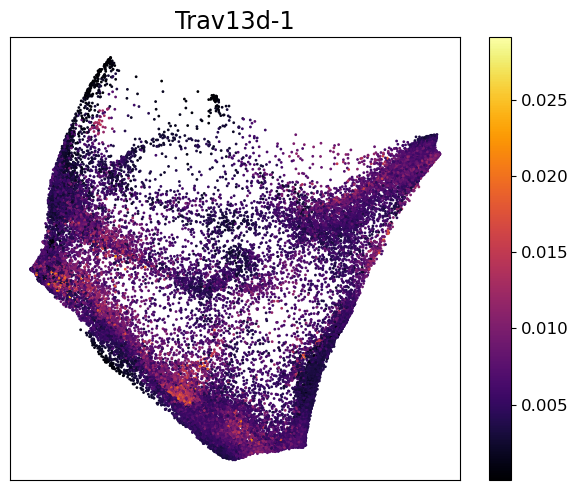

In [18]:
for gene in ['S1pr5', 'Tox', 'Rps20', 'Trav13d-1']:
    scprep.plot.scatter2d(adata.obsm['X_phate'], c=data_magic[gene], title=gene, ticks=None, figsize=(6,5),
                          dpi=200, filename=f'figures/{gene}.png')